In [1]:
from pathlib import Path
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import geopandas as gpd
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# Visualising global GDP and population growth

### Load data

In [2]:
data_path = Path('data')
out_path = Path('plots')

POP_DATA = data_path / 'population.csv'
GDP_DATA = data_path / 'gdp.csv'
WORLD_SHAPE = data_path / 'ne_10m_admin_0_countries.shp'

In [3]:
pop_df = pd.read_csv(POP_DATA)
print('Population data shape: {}'.format(pop_df.shape))
gdp_df = pd.read_csv(GDP_DATA)
print('GDP data shape: {}'.format(gdp_df.shape))

Population data shape: (278, 201)
GDP data shape: (195, 200)


In [4]:
pop_df.head()

,Unnamed: 0,1,Unnamed: 2,1000,Unnamed: 4,1500,Unnamed: 6,1600,Unnamed: 8,1700,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,Western Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Austria,500.0,NaN,700.0,NaN,2000.0,NaN,2500.0,NaN,2500.0,...,8113.413,8131.690,8148.312,8162.656,8174.762,8184.691,8192.880,8199.783,8205.533,8210
2,Belgium,300.0,NaN,400.0,NaN,1400.0,NaN,1600.0,NaN,2000.0,...,10263.618,10291.679,10311.970,10330.824,10348.276,10364.388,10379.067,10392.226,10403.951,10414
3,Denmark,180.0,NaN,360.0,NaN,600.0,NaN,650.0,NaN,700.0,...,5337.416,5355.826,5374.693,5394.138,5413.392,5432.335,5450.661,5468.120,5484.723,5501
4,Finland,20.0,NaN,40.0,NaN,300.0,NaN,400.0,NaN,400.0,...,5168.595,5180.309,5193.039,5204.405,5214.512,5223.442,5231.372,5238.460,5244.749,5250


In [5]:
gdp_df.head()

,Unnamed: 0,1,Unnamed: 2,1000,Unnamed: 4,1500,Unnamed: 6,1600,Unnamed: 8,1700,...,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
0,Western Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Austria,212.5,NaN,297.5,NaN,1414.0,NaN,2093.0,NaN,2483.0,...,162410.0,167878.0,169244.0,170755.0,172763.0,176795.0,181215.0,187557.0,194122.0,198004.0
2,Belgium,135.0,NaN,170.0,NaN,1225.0,NaN,1561.0,NaN,2288.0,...,204349.0,212010.0,213668.0,216891.0,219074.0,225609.0,230572.0,237490.0,243666.0,246103.0
3,Denmark,72.0,NaN,144.0,NaN,443.0,NaN,569.0,NaN,727.0,...,118399.0,122628.0,123502.0,124062.0,124543.0,127175.0,130227.0,134525.0,136677.0,135037.0
4,Finland,8.0,NaN,16.0,NaN,136.0,NaN,215.0,NaN,255.0,...,97261.0,102185.0,104880.0,106570.0,108490.0,112500.0,115650.0,121317.0,126412.0,127676.0


### Clean data

In [6]:
def clean_df(df):
    """ 
    Tidy the input data sets to fit them logically into 
    Dataframes.
    
    Normalise them such that the GDP for each year recorded
    is a proportion of the global total rather than 
    the absolute value for inter-year consistency
    """
    df.drop(df[df[df.columns[0]].isnull()].index, inplace=True)
    df.set_index(df.columns[0], inplace=True)
    df.index = [i.strip().lower() for i in df.index]
    df.index.name = 'country'
    
    unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
    df.drop(columns=unnamed_cols, inplace=True)
    
    df.drop(df.index[df.index.isnull()], inplace=True)
    total_rows = [row for row in df.index if 'total' in row]
    df.drop(total_rows, inplace=True)
    return df


def normalise_by_year(df, bad_cols=[]):
    for col in df.columns:
        if not is_numeric_dtype(df[col]):
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                bad_cols.append(col)
                print('Dropping year %s due to non-'
                      'numeric data' % col)
    df.drop(columns=bad_cols, inplace=True)
    return df / df.sum(axis=0)

In [7]:
def fill_null_section(df, col, i=0):
    if all(df[col].isnull()):
        return df[col]
    
    null_found=False
    col_iloc = np.argmax(df.columns==col)
    
    for i, val in enumerate(df[col][i:]):
        if pd.isna(val) and i != len(df):
            null_found = True
            null_start_idx = i
            
            for null_section_i, null_section_val \
                in enumerate(df[col][null_start_idx:], start=null_start_idx):
                
                if not pd.isna(null_section_val):
                    null_end_idx = null_section_i
                    df.iloc[null_start_idx:null_end_idx, col_iloc] = \
                        df.iloc[null_start_idx:null_end_idx, col_iloc] \
                        .fillna(np.mean([df.iloc[null_start_idx-1, col_iloc], 
                                         df.iloc[null_end_idx, col_iloc]]))
                    break
            break
    if null_found:
        fill_null_section(df, col)
    return df[col]

In [8]:
print('Processing GDP df')
gdp_df = clean_df(gdp_df)
gdp_df = normalise_by_year(gdp_df)

print('Processing population df')
pop_df = clean_df(pop_df)
#pop_df = normalise_by_year(pop_df)

Processing GDP df
Dropping year 1865 due to non-numeric data
Processing population df


In [9]:
# Fill gaps in the DF over time
for col in tqdm(gdp_df.T.columns):
    gdp_df.T[col] = fill_null_section(gdp_df.T, col)

100%|███████████████████████████████████████| 174/174 [00:00<00:00, 296.42it/s]


### Check data

In [10]:
t_df = gdp_df.T
top_players = t_df.sum().sort_values(ascending=False)[:10]

In [11]:
t_df = t_df[list(top_players.index)]
#t_df = t_df[['france', 'germany']]

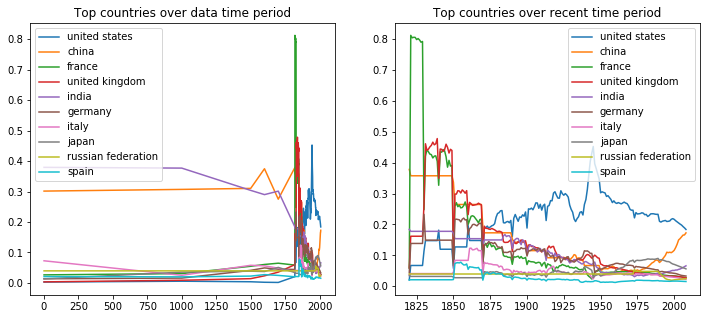

In [12]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[12, 5])
time = pd.to_numeric(t_df.index)
for country in t_df.columns:
    ax.plot(time, t_df[country], label=country)
    ax1.plot(time[time > 1800], t_df[country][time > 1800], label=country)
ax.legend()
ax1.legend()
ax.set_title('Top countries over data time period')
ax1.set_title('Top countries over recent time period')
plt.show()

In [13]:
gdp_df.T

country,western europe,austria,belgium,denmark,finland,france,germany,italy,netherlands,norway,...,south africa,sudan,swaziland,tanzania,togo,tunisia,uganda,zaire (congo kinshasa),zambia,zimbabwe
1,NaN,0.002388,0.001517,0.000809,0.000090,0.026584,0.013764,0.072752,0.000955,0.000449,...,0.002800,0.001281,0.000055,0.000640,0.000104,0.004944,0.000701,0.000964,0.000271,0.000294
1000,NaN,0.003321,0.001898,0.001607,0.000179,0.030842,0.016018,0.025116,0.001423,0.000893,...,0.002800,0.001281,0.000055,0.000640,0.000104,0.002783,0.000701,0.000964,0.000271,0.000294
1500,NaN,0.007098,0.006149,0.002224,0.000683,0.054776,0.041444,0.057979,0.003629,0.000919,...,0.002800,0.001281,0.000055,0.000640,0.000104,0.002783,0.000701,0.000964,0.000271,0.000294
1600,NaN,0.008169,0.006092,0.002221,0.000839,0.060725,0.049395,0.056240,0.008087,0.001038,...,0.002800,0.001281,0.000055,0.000640,0.000104,0.002783,0.000701,0.000964,0.000271,0.000294
1700,NaN,0.008241,0.007594,0.002413,0.000846,0.064850,0.045304,0.048557,0.013432,0.001198,...,0.002800,0.001281,0.000055,0.000640,0.000104,0.002783,0.000701,0.000964,0.000271,0.000294
1820,NaN,0.006790,0.007493,0.002434,0.001510,0.058679,0.044370,0.037283,0.007094,0.001285,...,0.001064,0.001281,0.000055,0.000640,0.000104,0.000622,0.000701,0.000964,0.000271,0.000294
1821,NaN,0.018863,0.019621,0.032484,0.001766,0.812085,0.138634,0.041152,0.093974,0.003575,...,0.001640,0.001281,0.000055,0.000640,0.000104,0.000688,0.000701,0.000964,0.000271,0.000294
1822,NaN,0.018863,0.019621,0.033749,0.001766,0.804167,0.138634,0.041152,0.097060,0.003575,...,0.001640,0.001281,0.000055,0.000640,0.000104,0.000688,0.000701,0.000964,0.000271,0.000294
1823,NaN,0.018863,0.019621,0.032561,0.001766,0.805829,0.138634,0.041152,0.097892,0.003575,...,0.001640,0.001281,0.000055,0.000640,0.000104,0.000688,0.000701,0.000964,0.000271,0.000294
1824,NaN,0.018863,0.019621,0.032425,0.001766,0.805599,0.138634,0.041152,0.098041,0.003575,...,0.001640,0.001281,0.000055,0.000640,0.000104,0.000688,0.000701,0.000964,0.000271,0.000294


### Merge to GeoDF

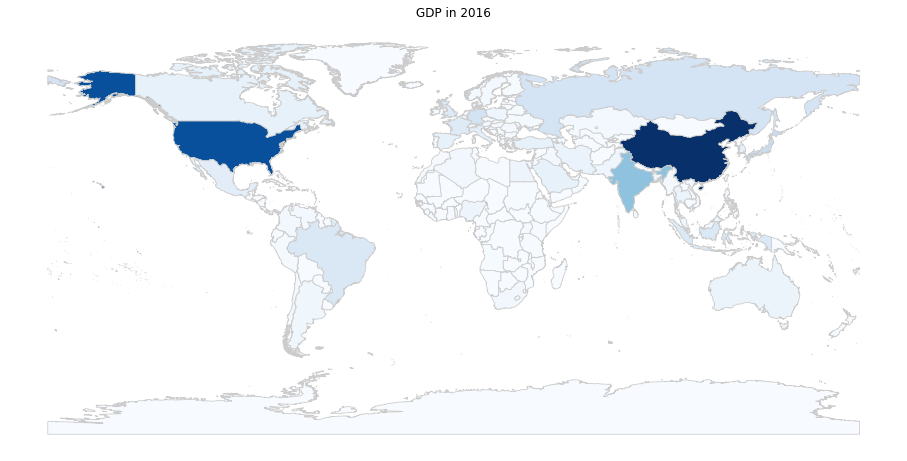

In [14]:
map_df = gpd.read_file(str(WORLD_SHAPE))
map_df.head()

fig, ax = plt.subplots(1, figsize=(16, 8))
map_df.plot(
    column='GDP_MD_EST', 
    cmap='Blues', 
    linewidth=0.8, 
    ax=ax, 
    edgecolor='0.8'
)
ax.axis('off')
ax.set_title('GDP in 2016')
plt.show()

In [15]:
# Mapping shaped file names -> GDP data names
def rename(col):
    name_dict = {
        'united states of america': 'united states'
    }
    for curr_name, data_name in name_dict.items():
        col[col.str.lower().str.strip() == curr_name] = data_name
    return col

In [16]:
# Set geopandas df's index to the country name and tidy a bit
map_df = map_df[map_df['TYPE'].isin(['Sovereign country', 'Country'])]
map_df['SOVEREIGNT'] = rename(map_df['SOVEREIGNT'])
plot_df = map_df.set_index('SOVEREIGNT')
plot_df.index = [i.strip().lower() for i in plot_df.index]

# Merge to the GDP over time data
plot_df = plot_df.merge(gdp_df, left_index=True, right_index=True, how='left')
plot_df.head()

,featurecla,scalerank,LABELRANK,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,GEOU_DIF,...,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
afghanistan,Admin-0 country,0,3,AFG,0,2,Sovereign country,Afghanistan,AFG,0,...,0.000382,0.000364,0.000319,0.000396,0.000439,0.000450,0.000499,0.000513,0.000550,0.000552
albania,Admin-0 country,0,6,ALB,0,2,Sovereign country,Albania,ALB,0,...,0.000251,0.000257,0.000268,0.000268,0.000271,0.000273,0.000276,0.000276,0.000281,0.000291
algeria,Admin-0 country,0,3,DZA,0,2,Sovereign country,Algeria,DZA,0,...,0.002402,0.002349,0.002343,0.002356,0.002409,0.002408,0.002416,0.002341,0.002310,0.002306
andorra,Admin-0 country,0,6,AND,0,2,Sovereign country,Andorra,AND,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
angola,Admin-0 country,0,3,AGO,0,2,Sovereign country,Angola,AGO,0,...,0.000219,0.000215,0.000216,0.000239,0.000236,0.000250,0.000287,0.000324,0.000373,0.000409


### Plot over time

In [17]:
for year in tqdm(gdp_df.columns):
    fig, ax = plt.subplots(1, figsize=(16, 8))
    plot_df.plot(
        column=year, 
        cmap='Blues', 
        linewidth=0.8, 
        ax=ax, 
        edgecolor='0.8'
    )
    ax.axis('off')
    ax.annotate(
        'Angus Maddison Historical Statistics: http://www.ggdc.net/MADDISON/oriindex.htm',
        xy=(0.1, .08),  
        xycoords='figure fraction', 
        horizontalalignment='left', 
        verticalalignment='top', 
        fontsize=12, 
        color='#555555'
    )
    ax.annotate(
        year,
        xy=(0.1, .4),  
        xycoords='figure fraction', 
        horizontalalignment='left', 
        verticalalignment='top', 
        fontsize=32, 
        color='#555555'
    )
    ax.set_title('Global GDP distribution', 
                 horizontalalignment='left',
                 x=0.05,
                 color='#555555',
                 fontsize=32)

    file_path = out_path / ('global_gdp_year_%s.png' % year)
    fig.savefig(file_path)
    plt.close(fig)

  0%|                                                  | 0/193 [00:00<?, ?it/s]C:\Users\James\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
100%|████████████████████████████████████████| 193/193 [04:25<00:00,  1.34s/it]
